In [15]:
import random
import uuid
import itertools

import networkx as nx
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from IPython.display import HTML, Image

import numpy as np
import pandas as pd
from names import get_full_name
from coolname import generate_slug

%matplotlib inline

In [16]:
rc('animation', html='html5')

# Peer Assessment

The following notebook is part of a study on the design and evaluation of a peer-to-peer assessment method that utilizes an iterative ranking algorithm with a reputation redistribution process. **The hypothesis is that summative peer-to-peer assessment can be accurately evaluated as a function of a student’s produced work and her ability to critically analyze other students’ work within the same subject.**

This research draws heavily on studies in other domains. Most notably, a study to improve the accuracy and robustness of online consumer ratings by employing a reputation redistribution process. *Ranking reputation and quality in online rating systems* defines and evaluates a  methodology for improving the accuracy and robustness of online consumer ratings by employing a reputation redistribution process (Liao et al., 2014). The similarities between consumer ratings and peer-to-peer assessment are manifest in the bipartite network which features human raters on one side and objects to be evaluated on the other. Due to these similarities it is hypothesized that the algorithms developed to improve the robustness and accuracy of consumer ratings and academic paper rankings are transferable to peer-to-peer assessment.


## EPFL Peer Assessment Dataset

The Swiss Federal Institute of Technology in Lausanne (EPFL) created a peer assessment dataset in 2013. The data was generated from a social media class consisting of 60 Master's level students and 4 instructors. Each student participant was instructed to hand in a two-page report showing the long-tail effect in the social media platform of that student's choice. The students were then randomly assigned 20 reports to assess and told that "their peer evaluations would only be taken into account if they did not deviate significantly from the evaluation carried out by the instructors". Grades were performed on a 5-point Likert scale akin to rating systems used for online consumer ratings: (1) I hate the report, (2) I don't like the report, (3) The report is OK, (4) I like the report, (5) I love the report (Vozniuk et al., 2016).

### Dataset Structure

The data is normalized into three tsv tables:
* grades_instructors_all.tsv - has the grades assigned by instructors
* grades_students_all.tsv - has the grades assigned by students
* students_reports_mapping - maps student IDs to report IDs

There are 60 reports for each student, 1106 student grades, and 240 instructor grades. If students were each assigned 20 reports to peer grade, it is unclear why there are not 1200 student grades.

### Dataset limitations

This dataset only represents peer assessment on a single assignment in a single class over a single semester at a single University. Not only could this data be subject to factors specific to the setting, there is no longitudinal aspect to this data. Therefore it is impossible to test whether a student's reputation over time has an impact on grading accuracy. Furthermore, the participants are Master's students at a traditional university which means they might not represent the total population of MOOC users. The last significant limitation of the data may be the grading methodology. Research has shown that student assessments fall more closely to that of the instructor if grading criteria is provided for them (Falchikov, & Goldfinch, 2000). The authors of this dataset give no indication that a detailed rubric was provided to students for grading. The literature also shows that anonymity is important in peer assessment because students are hesitant to accurately but negatively assess their friends (Strachan & Wilcox, 1996, Davies, 2000). Although the authors indicate that grades were submitted via an online platform called Graasp, they give no indication whether or not these submissions were anonymous. Despite these limitations, this data helps identify some of the challenges of implementing a peer grading algorithm and is therefore adequate for an early iteration of development.

In [6]:
instructor_grades = pd.read_csv('./dataset/grades_instructors_all.tsv', sep='\t')
student_grades = pd.read_csv('./dataset/grades_students_all.tsv', sep='\t')
student_reports = pd.read_csv('./dataset/students_reports_mapping.tsv', sep='\t')

### Anaylsis of Reports

`student_reports` contains two columns:
* student_id - represents the unique identifier of the student that submitted the report
* report_id - represents the unique identifier of the report to be graded

The reports represent two-page papers on the long-tail effect of the social media platform of each student's choice. 
* 60 unique students submitted 60 unique reports 
* Every student submitted only one report
* Each report had only one student submitter

In [7]:
student_reports['student_id'].nunique() == student_reports.shape[0]

True

In [8]:
student_reports['report_id'].nunique() == student_reports.shape[0]

True

In [9]:
(student_reports['report_id'].value_counts() == 1).all()

True

In [10]:
(student_reports['student_id'].value_counts() == 1).all()

True

### Analysis of Student Grades

`student_grades` contains 3 columns:
* student_id - represents the unique identifier of the student that graded the report
* report_id - represents the unique identifier of the report that was graded
* grade - the grade assigned to the report by the student

Grades were assigned on a 5 point Likert scale by 57 students.
* Most students, but not all, graded 20 reports
* Reports did not receive a uniform number of student grades
* Peer grades skew high
* The mean peer score was ~3.84
* No report received a perfect score from peers
* Only 3 reports averaged a score below 3 from peers
* Students tend to be positively biased in their grading

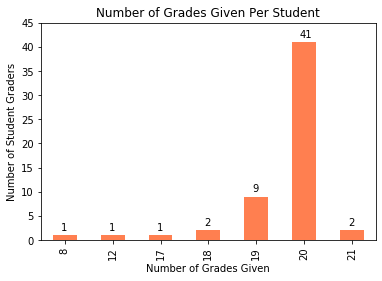

In [41]:
# Most students, but not all, graded 20 reports
data = student_grades['student_id'].value_counts().value_counts().sort_index()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0,45))
ax.set_ylabel('Number of Student Graders')
ax.set_xlabel('Number of Grades Given')
ax.set_title('Number of Grades Given Per Student')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_width()/3 + p.get_x() * p.get_width() * 2, p.get_height() + 1))

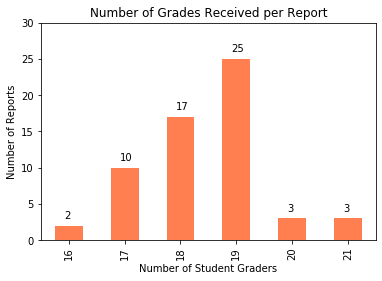

In [42]:
# Reports did not receive a uniform number of student grades
data = student_grades['report_id'].value_counts().value_counts().sort_index()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0,30))
ax.set_ylabel('Number of Reports')
ax.set_xlabel('Number of Student Graders')
ax.set_title('Number of Grades Received per Report')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_width()/3 + p.get_x() * p.get_width() * 2, p.get_height() + 1))

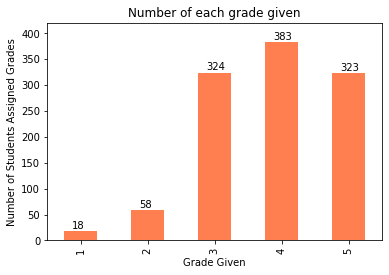

In [73]:
# peer grades skew high
data = student_grades['grade'].value_counts().sort_index()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0, 420))
ax.set_ylabel('Number of Students Assigned Grades')
ax.set_xlabel('Grade Given')
ax.set_title('Number of each grade given')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_width()/4 + p.get_x() * p.get_width() * 2, p.get_height() + 5))

Mean: 3.8444359878454306


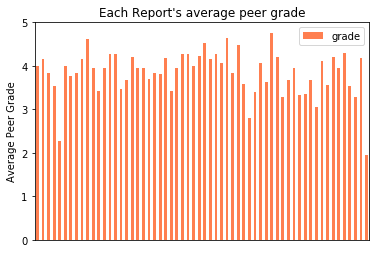

In [56]:
# The mean peer score was ~3.84
# No report received a perfect score from peers
# Only 3 reports averaged a score below 3 from peers
data = student_grades[['report_id', 'grade']].groupby('report_id').mean()
ax = data.plot(kind='bar', color='coral')
ax.set_ylabel('Average Peer Grade')
ax.set_title('Each Report\'s Average Peer Grade')
ax.xaxis.set_visible(False)

print('Mean:', data['grade'].mean())

Mean: 3.847006448008566
Grades < 3: 3


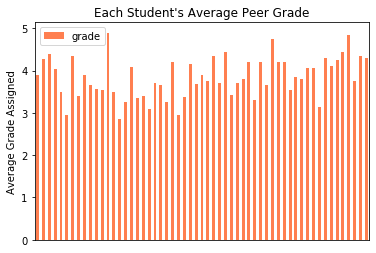

In [86]:
# Students tend to be positively biased in their grading
data = student_grades[['student_id', 'grade']].groupby('student_id').mean() #.sort_values('grade')
ax = data.plot(kind='bar', color='coral')
ax.set_ylabel('Average Grade Assigned')
ax.set_title('Each Student\'s Average Peer Grade')
ax.xaxis.set_visible(False)

print('Mean:', data['grade'].mean())
print('Grades < 3:', data[data['grade'] < 3]['grade'].count())

### Analysis of Instructor Grades

`instructor_grades` contains 3 columns:
* instructor_id - represents the unique identifier of the instructor that graded the report
* report_id - represents the unique identifier of the report that was graded
* grade - the grade assigned to the report by the instructor

Grades were assigned on a 5 point Likert scale by 4 instructors.
* All 4 instructors graded all 60 reports
* Instructor grades skew high
* The mean instructor score was ~3.6
* One report received a perfect score from the instructors
* Only 9 reports averaged a score below 3 from the instructors

In [87]:
# All 4 instructors graded all 60 reports
instructor_grades['instructor_id'].value_counts()

887     60
107     60
1033    60
5       60
Name: instructor_id, dtype: int64

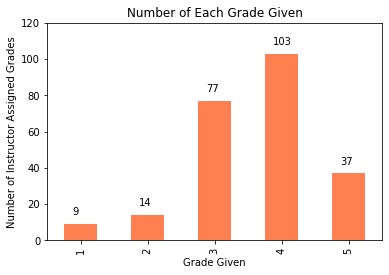

In [88]:
# instructor grades skew high
data = instructor_grades['grade'].value_counts().sort_index()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0, 120))
ax.set_ylabel('Number of Instructor Assigned Grades')
ax.set_xlabel('Grade Given')
ax.set_title('Number of Each Grade Given')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_width()/4 + p.get_x() * p.get_width() * 2, p.get_height() + 5))

Mean: 3.6041666666666665
Grades < 3: 9


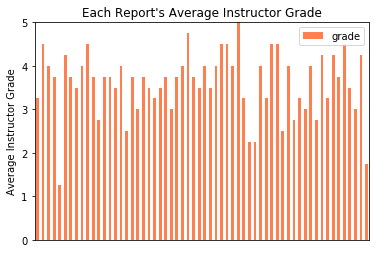

In [91]:
# The mean instructor score was ~3.6
# One report received a perfect score from the instructors
# Only 9 reports averaged a score below 3 from the instructors
data = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0, 5))
ax.set_ylabel('Average Instructor Grade')
ax.set_title('Each Report\'s Average Instructor Grade')
ax.xaxis.set_visible(False)

print('Mean:', data['grade'].mean())
print('Grades < 3:', data[data['grade'] < 3]['grade'].count())

Mean: 3.604166666666667
Grades < 3: 0


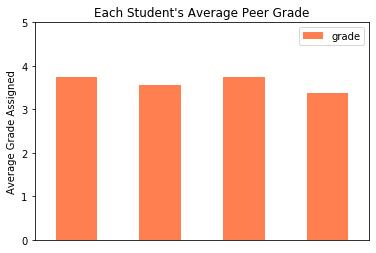

In [92]:
# Instructors tend to be positively biased in their grading
data = instructor_grades[['instructor_id', 'grade']].groupby('instructor_id').mean()
ax = data.plot(kind='bar', color='coral')
ax.set_ylim((0, 5))
ax.set_ylabel('Average Grade Assigned')
ax.set_title('Each Student\'s Average Peer Grade')
ax.xaxis.set_visible(False)

print('Mean:', data['grade'].mean())
print('Grades < 3:', data[data['grade'] < 3]['grade'].count())

## Synthetic Data

To create synthetic data, we create two sets: $U$ and $O$. These represent students and submissions respectively. We assume that each submission $x$ has an intrinsic quality denoted by $Q^\prime_x$. When a user $i$ gives a rating to a submission $x$, he/she will have some magnitude of rating error $\delta_{ix}$.

### Initializing the Data

In [235]:
def generate_student_data(num_students):
    data = []
    for i in range(num_students):
        data.append({
            'id': uuid.uuid4(),
            'name': get_full_name(),
            'error': random.uniform(0.1, 0.5),
            'reputation': 0
        })
    df = pd.DataFrame(data)
    df.set_index('id', inplace=True)
    return df

In [236]:
def generate_submission_data(student_df, num_assignments):
    data = []
    for i in range(num_assignments):
        assignment_name = generate_slug(2)
        for j in range(student_df.shape[0]):
            data.append({
                'id': uuid.uuid4(),
                'assignment': assignment_name,
                'submitter': student_df.index.values[j],
                'quality': random.uniform(0,1)
            })
    df = pd.DataFrame(data)
    df.set_index('id', inplace=True)
    return df

In [237]:
def initialize_data(num_students, num_assignments):
    student_df = generate_student_data(num_students)
    submission_df = generate_submission_data(student_df, num_assignments)
    return (student_df, submission_df)

In [238]:
(student_df, submission_df) = initialize_data(10, 2)

### Generating Ratings

## References

1. Falchikov, N., & Goldfinch, J. (2000). Student peer assessment in higher education: A meta-analysis comparing peer and teacher marks. Review of educational research, 70(3), 287-322.
1. Liao, H., Zeng, A., Xiao, R., Ren, Z. M., Chen, D. B., & Zhang, Y. C. (2014). Ranking reputation and quality in online rating systems. PloS one, 9(5), e97146.
1. Vozniuk, Andrii & Holzer, Adrian & Gillet, Denis. (2016). Peer Assessment Dataset. Journal of Learning Analytics. 3.322-324. 10.18608/jla.2016.32.18.